# In this note the SCAN algorithm will be trained for 5 clusters and on custom mean and std.

1. Training the pretext part 

2. Plot the clusters using pretext model + Kmeans :

3. Train the scan model 

## Visualizing the cluster images
For this each image is fed throught the model and its cluster label is noted. The all images belong to same cluster (having same labels) are plotted together.


In [ ]:
!nvidia-smi

Mon Dec 14 13:09:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Omdena/Unsupervised\ Methods/Unsupervised-Classification/SCAN
!ls -lh

[Errno 2] No such file or directory: 'drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN'
/content/drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN
total 745K
-rw------- 1 root root 174K Dec  4 09:41  all_before_attack_images.jpg
drwx------ 2 root root 4.0K Nov 25 14:10  cifar-10
drwx------ 2 root root 4.0K Nov 25 14:10  configs
drwx------ 2 root root 4.0K Nov 25 14:10  data
drwx------ 2 root root 4.0K Nov 25 14:31  euroSAT
-rw------- 1 root root 5.9K Nov 25 06:07  eval.py
drwx------ 2 root root 4.0K Dec  3 14:01  kenya_jpeg
drwx------ 2 root root 4.0K Dec  7 13:02  KenyaModel_5CLS
drwx------ 2 root root 4.0K Dec  7 09:06  KenyaModel6CLS
drwx------ 2 root root 4.0K Dec  7 08:45  KenyaModel_6CLS
drwx------ 2 root root 4.0K Dec  6 11:32  KenyaModel_8CLS
-rw------- 1 root root 159K Dec  8 04:51  kmeans.jpg
-rw------- 1 root root 1.2K Dec  6 16:13  kmeans_labels_6.npy
-rw------- 1 root root 1.2K Dec  4 07:01  kmeans_labels.npy
drwx------ 

# Visualzing sentinal-2 dataset

In [ ]:
!pip install pyyaml easydict                 # For using config files
!pip install termcolor   
!pip install faiss-gpu

     |████████████████████████████████| 67.7MB 49kB/s 


In [ ]:
import os 
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


In [ ]:
#apath to kenya dataset 
before_img_path = Path('../../../Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/kenya_before/')
before_img_path


PosixPath('../../../Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/kenya_before')

Number of Images

In [ ]:
tif_images = os.listdir(before_img_path)
len(tif_images)

259

Size of images 

In [ ]:
!pip install -q rasterio

     |████████████████████████████████| 18.3MB 175kB/s 


In [ ]:
import rasterio as rio
from rasterio.plot import show 

In [ ]:
def normalize(x):
  return x / x.max()

def normMinMax(x):

  return ((x - x.min()) / (x.max() - x.min()) * 255).astype(int)


(3, 153, 153)


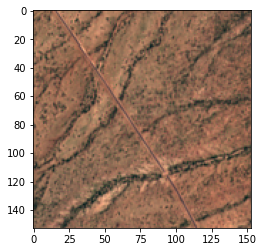

In [ ]:
for root,_,img_names in os.walk(before_img_path):
    for img in img_names: 
        path = os.path.join(root,img)
        tiff_image = rio.open(path).read([4,3,2])
        print(tiff_image.shape)
        show(normMinMax(tiff_image))
        break


In [ ]:
images = []
for root,_,img_names in os.walk(before_img_path):

    for img in img_names: 

        path = os.path.join(root,img)
        tiff_image = rio.open(path).read([4,3,2])

        images.append(normMinMax(tiff_image))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


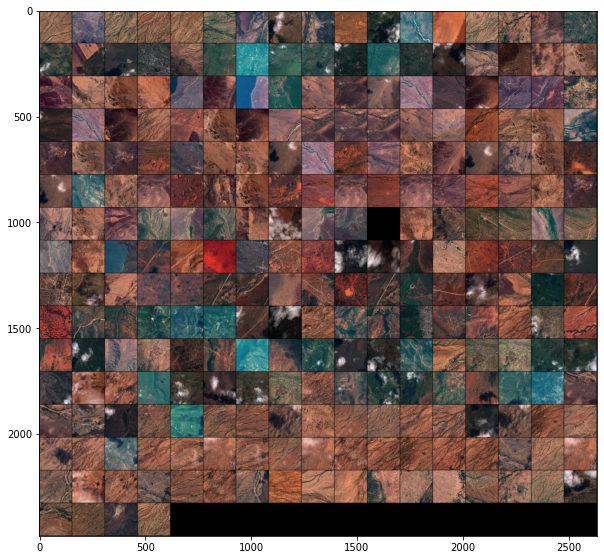

In [ ]:
import torch
from torchvision.utils import make_grid


grid = make_grid(torch.tensor(images),nrow = 17)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid,(1,2,0)))


In [ ]:
!ls

 all_before_attack_images.jpg   pre_text_kmeans_cls_5.jpg
 cifar-10		        pretext_kmeans_labels_5_cls.npy
 configs		       'Pseudo Labels'
 data			       'Pseudo Labels 5 CLS'
 euroSAT		       'Pseudo Labels 6 CLS'
 eval.py		        requirements.txt
 kenya_jpeg		        scan_labels.jpg
 KenyaModel_5CLS	        SCAN_preds_5.csv
 KenyaModel6CLS		        SCAN_preds_6.csv
 KenyaModel_6CLS	        SCAN_preds.csv
 KenyaModel_8CLS	        scan.py
 kmeans.jpg		        selflabel.py
 kmeans_labels_6.npy	        setup.py
 kmeans_labels.npy	        simclr.py
 losses			        utils
 models


In [ ]:
# #saving images in kenya_jpeg folder 

# folder = 'kenya_jepg/'


# for i,img in enumerate(images):
#     plt.imsave(folder + f'images_{i}.jpeg',img.transpose(1,2,0).astype('uint8'))



# Calculating Mean and Std

In [ ]:
from data.kenyaDataset import KenyaDataset 
from torchvision.transforms import Compose,ToTensor


transform = Compose([ToTensor()])


dataset = KenyaDataset('kenya_jpeg/',transform = transform )


total_pix = len(dataset) * 153 * 153

mean = {'red':0,'green':0,'blue':0}
std =  {'red':0,'green':0,'blue':0}

for i in range(259):

    data = dataset[i]['image']
    mean['red'] += data[0,:,:].sum()
    mean['green'] += data[1,:,:].sum()
    mean['blue'] += data[2,:,:].sum()


mean['red'] /= total_pix
mean['green'] /= total_pix
mean['blue'] /= total_pix

In [ ]:
mean

{'blue': tensor(0.2831), 'green': tensor(0.3090), 'red': tensor(0.4049)}

In [ ]:
#std 
import torch

for i in range(259):

    data = dataset[i]['image']
    std['red'] += ((data[0,:,:] - mean['red']).pow(2)).sum()
    std['green'] += ((data[1,:,:] - mean['blue']).pow(2)).sum()
    std['blue'] += ((data[2,:,:] - mean['green']).pow(2)).sum()



std['red'] = torch.sqrt(std['red'] / total_pix)
std['green'] = torch.sqrt(std['green'] / total_pix)
std['blue'] = torch.sqrt(std['blue'] / total_pix)

std

{'blue': tensor(0.1679), 'green': tensor(0.1792), 'red': tensor(0.2702)}

# Pretext 

In [ ]:
!python simclr.py --config_env configs/env.yml --config_exp configs/pretext/simclr_kenya_custom.yml

{'setup': 'simclr', 'train_dir': 'KenyaModel_5CLS', 'backbone': 'resnet18', 'model_kwargs': {'head': 'mlp', 'features_dim': 128}, 'train_db_name': 'KenyaDataset', 'num_classes': 5, 'criterion': 'simclr', 'criterion_kwargs': {'temperature': 0.1}, 'epochs': 500, 'optimizer': 'sgd', 'optimizer_kwargs': {'nesterov': False, 'weight_decay': 0.0001, 'momentum': 0.9, 'lr': 0.01}, 'scheduler': 'cosine', 'scheduler_kwargs': {'lr_decay_rate': 0.1}, 'batch_size': 32, 'num_workers': 8, 'augmentation_strategy': 'simclr', 'augmentation_kwargs': {'random_resized_crop': {'size': 153, 'scale': [0.2, 1.0]}, 'color_jitter_random_apply': {'p': 0.8}, 'color_jitter': {'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.4, 'hue': 0.1}, 'random_grayscale': {'p': 0.2}, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'transformation_kwargs': {'crop_size': 153, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'pretext_dir': './KenyaModel_5CLS/pret

In [ ]:
import torch


train_dir = "./KenyaModel_6CLS"


pretrain_path = train_dir + "/pretext/model.pth.tar"

state_dict = torch.load(pretrain_path)


from models.models import ContrastiveModel
from models.resnet_cifar import resnet18
backbone = resnet18()
model = ContrastiveModel(backbone,head='mlp',features_dim=128)
        # model = ContrastiveModel(backbone, **p['model_kwargs'])
model.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/pretext/simclr_kenya.yml')
transforms = get_val_transformations(p)
print(transforms)
train_dataset = get_train_dataset(p, transforms)
loader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=1)


model = model.cuda()
model.eval()


data_file = {'pred':[]}

for data in tqdm(loader):
    data_file['pred'].append(model(data['image'].cuda()).cpu().detach().numpy())
    

Compose(
    CenterCrop(size=(153, 153))
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
)
loading kenya dataset ....


100%|██████████| 259/259 [00:32<00:00,  7.96it/s]


In [ ]:
!pwd

/content/drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN


In [ ]:
pca_images = []
# /content/drive/MyDrive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN/kenya_jpeg/image_0.jpeg
from PIL import Image 

folder = 'kenya_jpeg/'

for i in os.listdir(folder):

    img_path = os.path.join(folder + i)
    img = Image.open(img_path)
    pca_images.append(np.array(img).reshape(1,-1))

pca_images = np.vstack(pca_images)
pca_images.shape

(259, 70227)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
dims = pca.fit_transform(pca_images)

# Kmeans 

In [ ]:
kmeans_data = np.vstack(data_file['pred'])
kmeans_data.shape

(259, 128)

In [ ]:
from sklearn.cluster import KMeans  


kmeans = KMeans(n_clusters = 6)
kmeans.fit(kmeans_data)

labels = kmeans.labels_


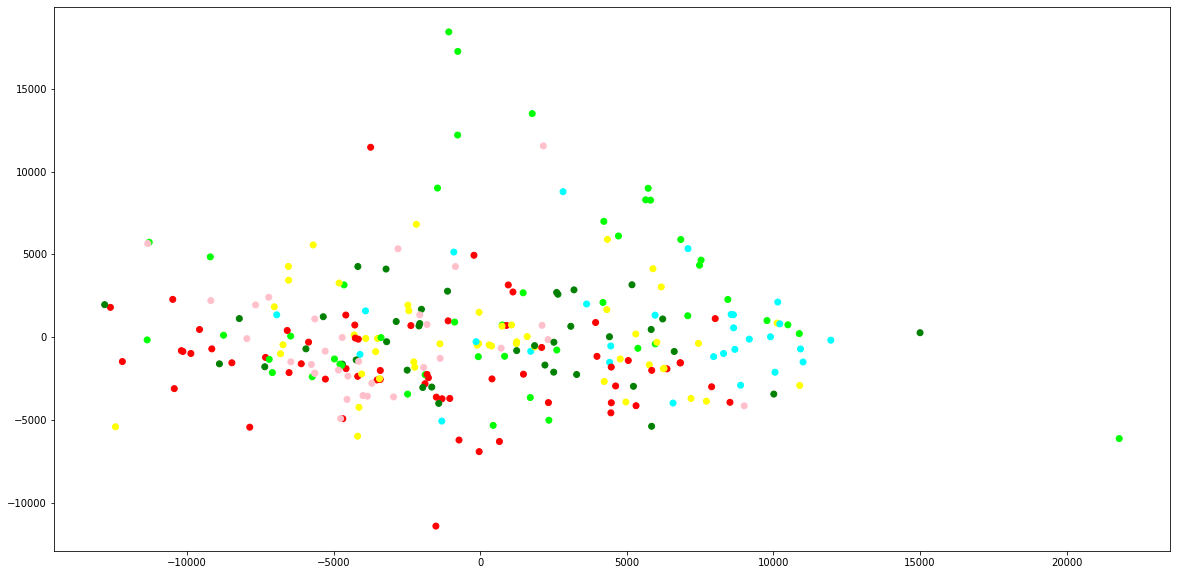

In [ ]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['pink','red','green','blue','yellow','lime','cyan'])

plt.figure(figsize=(20,10))
plt.scatter(dims[:,0],dims[:,1],c = labels,cmap = colors)
  # plt.legend(handles=scatter.legend_elements()[0], labels=classes)

In [ ]:
folder = 'kenya_jpeg/'

images = []
for i in os.listdir(folder):

    img_path = os.path.join(folder + i)
    img = Image.open(img_path)
    img = np.array(img)
    images.append(img)
  



In [ ]:
np.asarray(images).shape

(259, 153, 153, 3)

## Scatter plot with Images 

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import annotate

def imscatter(x, y, labels,images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0,l in zip(x, y, images,labels):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        bc = annotate(str(l),(x0,y0),xycoords='data',c = colors[l],fontweight = "extra bold",fontsize = "xx-large")
        artists.append(ax.add_artist(ab))
        artists.append(ax.add_artist(bc))

    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

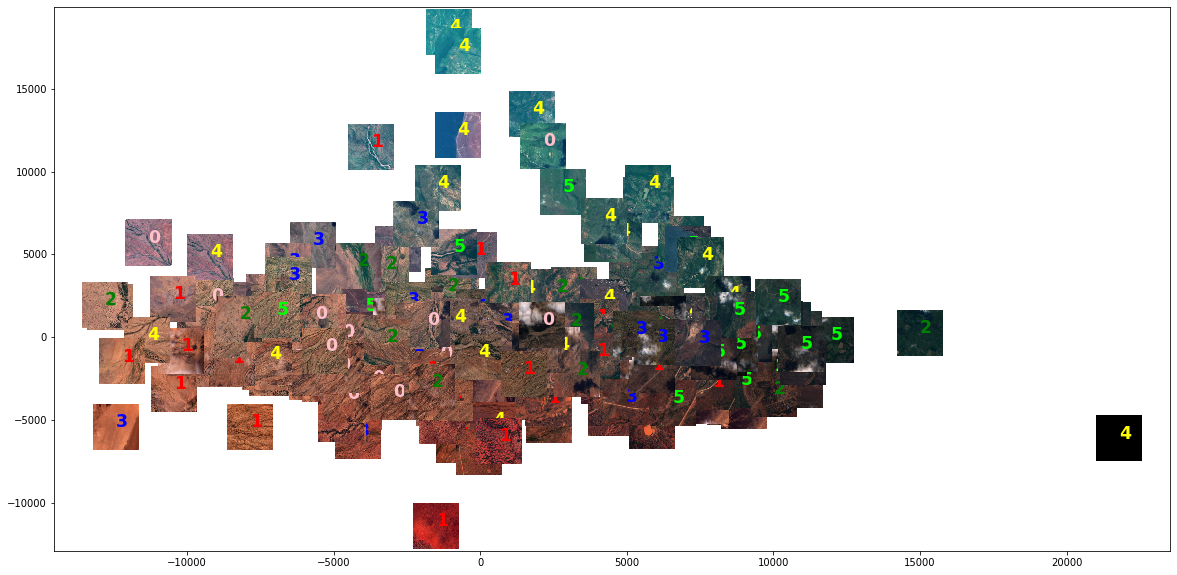

In [ ]:


colors = ['pink','red','green','blue','yellow','lime','cyan','coral']
   
plt.figure(figsize=(20,10))
imscatter(dims[:,0],dims[:,1],labels,images)
plt.savefig("pre_text_kmeans_cls_6.jpg")

In [ ]:
pd.Series(labels).value_counts()

1    63
3    50
4    46
2    39
0    32
5    29
dtype: int64

In [ ]:
# np.save('pretext_kmeans_labels_6_cls',labels)

# SCAN 

0 - 75 epochs : lr 0.001
76 onwards epochs : lr 0.0001



entropy_weight <20 and > 5

In [ ]:
# np.load('KenyaModel_5CLS/pretext/topk-train-neighbors.npy').shape

(259, 6)

In [ ]:
!python scan.py --config_env configs/env.yml --config_exp configs/scan/scan_kenya_custom.yml 

{'setup': 'scan', 'train_dir': 'KenyaModel_5CLS', 'criterion': 'scan', 'criterion_kwargs': {'entropy_weight': 5.0}, 'update_cluster_head_only': False, 'num_heads': 1, 'backbone': 'resnet18', 'train_db_name': 'KenyaDataset', 'num_classes': 5, 'num_neighbors': 5, 'augmentation_strategy': 'simclr', 'augmentation_kwargs': {'random_resized_crop': {'size': 153, 'scale': [0.2, 1.0]}, 'color_jitter_random_apply': {'p': 0.8}, 'color_jitter': {'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.4, 'hue': 0.1}, 'random_grayscale': {'p': 0.2}, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'transformation_kwargs': {'crop_size': 153, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'optimizer': 'sgd', 'optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0.0, 'nesterov': False, 'momentum': 0.9}, 'epochs': 150, 'batch_size': 32, 'num_workers': 8, 'scheduler': 'constant', 'pretext_dir': './KenyaModel_5CLS/pretext', 'pretext_checkpoint':

In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18
import torch

train_dir = './KenyaModel_6CLS'

path = train_dir + '/scan/model.pth.tar'

print('Model path : ',path)

state_dict = torch.load(path)

# print(state_dict['model'].keys())

backbone = resnet18()
model = ClusteringModel(backbone, 6, 1)
model.load_state_dict(state_dict['model'])
model = model.cuda()
model.eval()


Model path :  ./KenyaModel_6CLS/scan/model.pth.tar


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:

#getting the config
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/scan/scan_kenya_custom.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)
train_dataset = get_train_dataset(p, transforms)

loader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=1)


data_file = {'index':[],'pred':[]}

for idx,data in enumerate(loader):
  
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    data_file['index'].append(idx)

loading kenya dataset ....


In [ ]:
import pandas as pd
pred_df = pd.DataFrame(data_file)

pred_df['pred'].value_counts()

1    50
0    50
5    44
4    40
2    38
3    37
Name: pred, dtype: int64

In [ ]:
# pred_df.to_csv('SCAN_preds_5.csv',index = False)

In [ ]:
# colors = ['pink','red','green','blue','yellow','lime','cyan','coral']
   
# plt.figure(figsize=(20,10))
# imscatter(dims[:,0],dims[:,1],pred_df['pred'].values,images)
# # plt.savefig("scan_labels.jpg")

# Creating 5 Folders. One for each cluster and then try to manually identify the cluster  (optional)

Classes = [ Annual Cropland,Perennial cropland,open grassland, wooded  grasslands, forestland, openwater,bare soil, otherland.]


## Creating  folders 

In [ ]:
!rm --r Pseudo\ Labels\ 5\ CLS\

In [ ]:
root = 'Pseudo Labels 6 CLS 2'
os.mkdir(root)

In [ ]:
for i in range(5):
    os.mkdir(f'{root}/{i}')

In [ ]:


p = create_config('configs/env.yml','configs/scan/scan_kenya_custom.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)
train_dataset = get_train_dataset(p, transform = None)


for idx,data in tqdm(enumerate(train_dataset)):

  
      trax_img = transforms(data['image'])

      folder_name = str(torch.argmax(model(trax_img.unsqueeze(dim = 0).cuda())[0],dim = 1).cpu().detach().numpy()[0])
      
      img_path = root + "/" + folder_name + f"/image_cluster_{folder_name}_{idx}.jpeg" 
  
      img = np.array(data['image'])
    
      plt.imsave(img_path,img)


      if idx == 258: break 
  

0it [00:00, ?it/s]

loading kenya dataset ....


254it [00:05, 42.40it/s]


# Reference Labels.

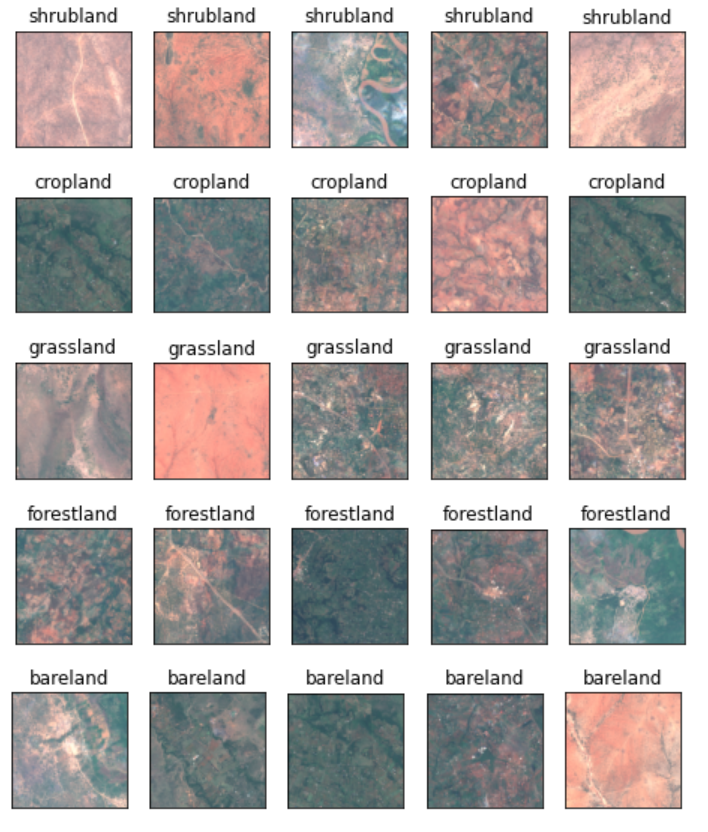

Link to all labels : https://drive.google.com/drive/folders/1TyF06Fa5LMyPoRerzROCfdS5Vqg1OOwu

# Do we have 8 classes or just 5 ? 

# PLotting all the Clusters 

In [ ]:
import torch
from torchvision.utils import make_grid
from PIL import Image

#helper function. 
def plot_clusters(root,cluster):

   folder = root + f"/{cluster}/"
   
   print(folder)

   print('no. of images : ',len(os.listdir(folder)))

   images = []
   for  img_name in  os.listdir(folder):
            image_path = folder + img_name 
            # print(img_name)
            img = Image.open(image_path)
            images.append(np.transpose(np.array(img),(2,0,1)))
    
   
  #  print(len(images))  

   grid = make_grid(torch.tensor(images),nrow = 8)
  #  print(grid.shape)
   plt.figure(figsize=(10,10)) 
   plt.imshow(np.transpose(grid,(1,2,0)))
   plt.savefig(root + f"/cluster__{cluster}.jpg")


# Cluster 0

Pseudo Labels 5 CLS/0/
no. of images :  64


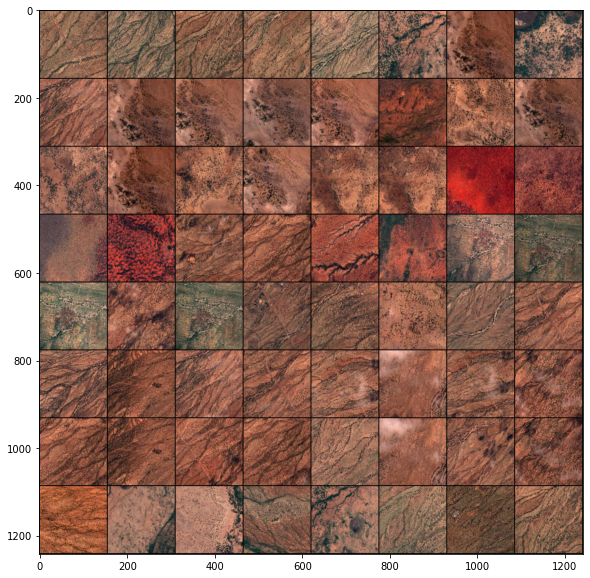

In [ ]:
plot_clusters(root,0)

# Cluster 1

Pseudo Labels 6 CLS 2/1/
no. of images :  50


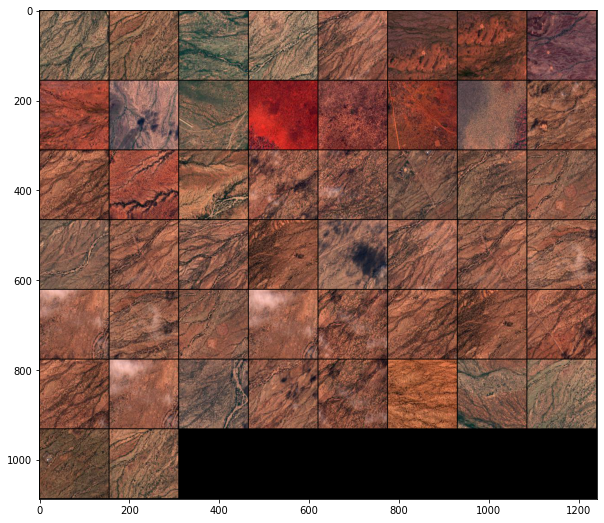

In [ ]:
plot_clusters(root,1)

# CLuster 2

Pseudo Labels 6 CLS 2/2/
no. of images :  38


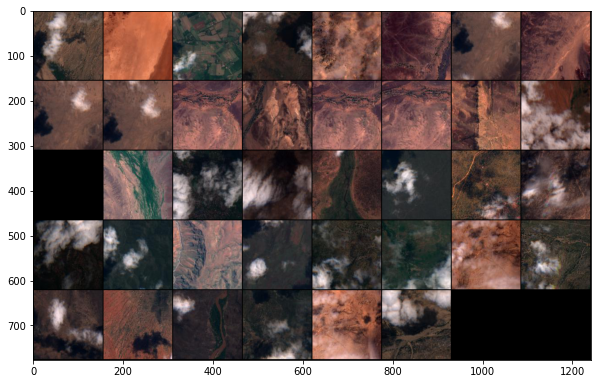

In [ ]:
plot_clusters(root,2)

#cluster 3

Pseudo Labels 6 CLS 2/3/
no. of images :  37


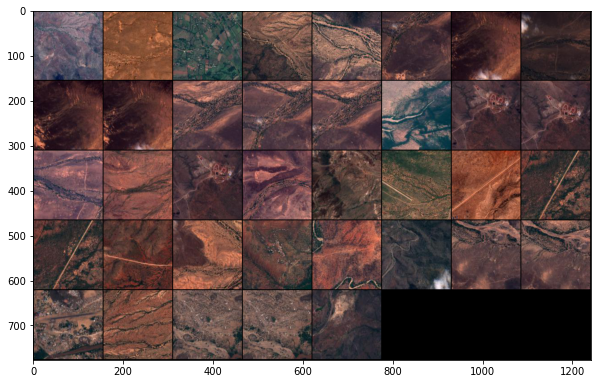

In [ ]:
plot_clusters(root,3)

#cluster 4

Pseudo Labels 5 CLS/4/
no. of images :  52


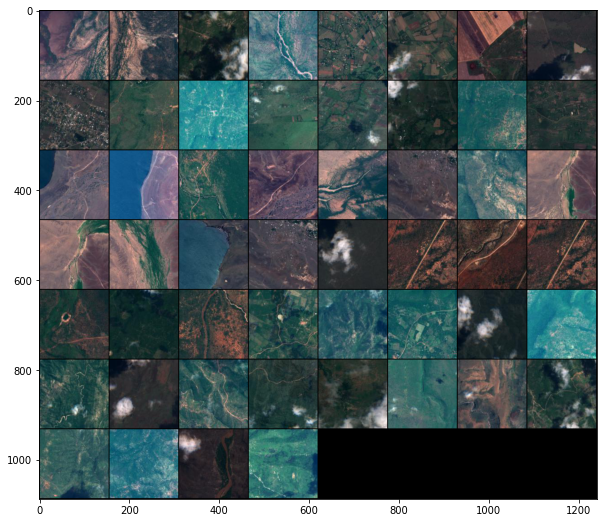

In [ ]:
plot_clusters(root,4)

# Validating Scan 

Trying to labbel the clusters using the test images provided by keyna red cross

In [ ]:
!pip install rasterio

     |████████████████████████████████| 18.3MB 1.3MB/s 


In [ ]:
%cd ./drive/My\ Drive/Omdena

/content/drive/My Drive/Omdena


In [ ]:
import rasterio as rio
from tqdm import tqdm 
from collections import defaultdict
from PIL import Image


data_dir = "../../../KenyaDataset/"
data = defaultdict(list)


for label in tqdm(os.listdir(data_dir)):
  
    for image in os.listdir(os.path.join(data_dir,label)):

        img_path = data_dir + label + "/" + image
        
        data[label].append(Image.fromarray(np.transpose(rio.open(img_path).read(),(1,2,0))))




100%|██████████| 6/6 [16:12<00:00, 162.04s/it]


In [ ]:
data.keys()

dict_keys(['shrubland', 'cropland', 'grassland', 'forestland', 'bareland', 'woodland'])

In [ ]:
[len(data[k]) for k in data.keys()]

[1145, 350, 194, 27, 26, 157]

In [ ]:
%cd Unsupervised Methods/Unsupervised-Classification/SCAN/

[Errno 2] No such file or directory: 'Unsupervised Methods/Unsupervised-Classification/SCAN/'
/content/drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN


In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18
import torch

train_dir = './KenyaModel_5CLS'

path = train_dir + '/scan/model.pth.tar'

print('Model path : ',path)

state_dict = torch.load(path)

# print(state_dict['model'].keys())

backbone = resnet18()
model = ClusteringModel(backbone, 5, 1)
model.load_state_dict(state_dict['model'])
model = model.cuda()
model.eval()


Model path :  ./KenyaModel_5CLS/scan/model.pth.tar


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config


p = create_config('configs/env.yml','configs/scan/scan_kenya_custom.yml')
transforms = get_val_transformations(p)

preds = defaultdict(list)



for classes in data.keys():

    for image in data[classes]:

        # plt.imshow(image)
        image = transforms(image)
        pred_class = torch.argmax(model(image.unsqueeze(dim = 0).cuda())[0].cpu(),1).numpy()[0]
        preds[classes].append(pred_class)

In [ ]:
import statistics 
{k : statistics.mode(preds[k]) for k in  preds.keys()}

{'bareland': 3,
 'cropland': 4,
 'forestland': 4,
 'grassland': 2,
 'shrubland': 3,
 'woodland': 3}